In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random

In [24]:
from keras.preprocessing.image import ImageDataGenerator

In [25]:
path = "main signs"  # folder with all the class folders
labelFile = 'labels.csv'  # file with all names of classes
batch_size_val = 50  # how many to process together
steps_per_epoch_val = 20
epochs_val = 10
imageDimesions = (32, 32, 3)
testRatio = 0.2  
validationRatio = 0.2  

In [26]:
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:",len(myList)-1)
noOfClasses=len(myList)-1
print("Importing Classes.....")
for x in range (0,noOfClasses):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")

Total Classes Detected: 4
Importing Classes.....
0 1 2 3  


In [27]:
images = np.array(images)
classNo = np.array(classNo)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)
print("Data Shapes:")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)

Data Shapes:
Train(1746, 32, 32, 3) (1746,)
Validation(437, 32, 32, 3) (437,)
Test(546, 32, 32, 3) (546,)


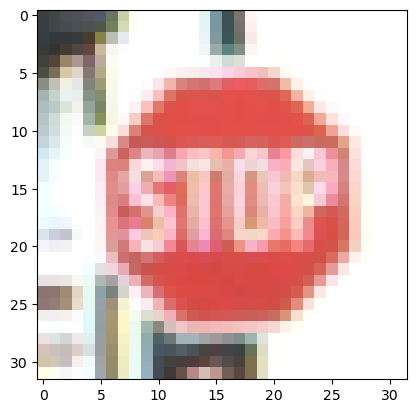

In [29]:
plt.imshow(images[40])

In [31]:
data = pd.read_csv(labelFile)
print("data shape ", data.shape, type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


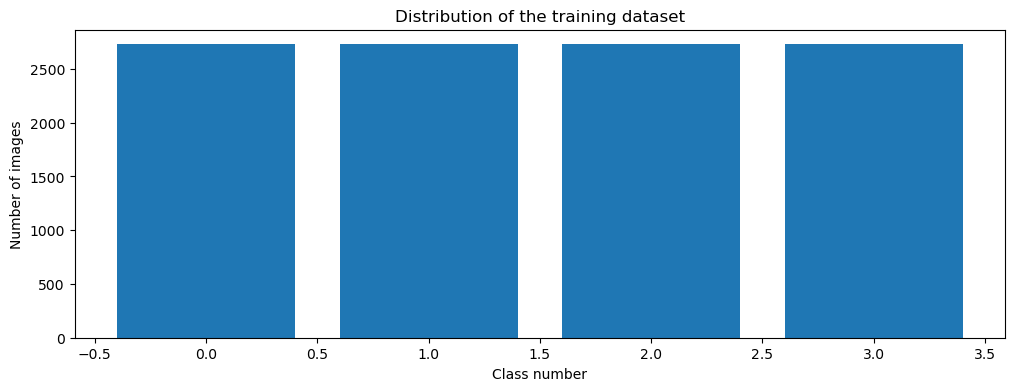

In [32]:
num_classes = noOfClasses
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), images.shape[0])
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [33]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):
    img = grayscale(img)  # CONVERT TO GRAYSCALE
    img = equalize(img)  # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img / 255  # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img

In [34]:
X_train = np.array(list(map(preprocessing, X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

In [35]:
X_train = X_train.reshape(X_train.shape [0],X_train.shape[1],X_train.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape [0],X_validation.shape[1],X_validation.shape[2],1)
X_test = X_test.reshape(X_test.shape [0],X_test.shape[1],X_test.shape[2],1)

In [36]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                             height_shift_range=0.1,
                             zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                             shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                             rotation_range=10)  # DEGREES
dataGen.fit(X_train)

batches = dataGen.flow(X_train, y_train,
                   batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREATED EACH TIME ITS CALLED
X_batch, y_batch = next(batches)

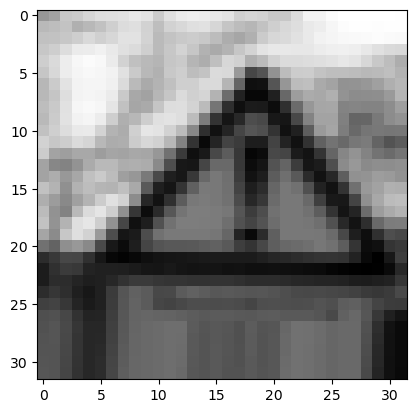

In [37]:
plt.imshow(X_batch[0].reshape(imageDimesions[0],imageDimesions[1]),cmap='gray')

In [38]:
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

In [39]:
def myModel():
    no_Of_Filters = 60
    size_of_Filter = (5, 5)  # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
    # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
    size_of_Filter2 = (3, 3)
    size_of_pool = (2, 2)  # SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500  # NO. OF NODES IN HIDDEN LAYERS
    model = Sequential()
    model.add((Conv2D(no_Of_Filters, size_of_Filter, input_shape=(imageDimesions [0],imageDimesions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))  # DOES NOT EFFECT THE DEPTH/NO OF FILTERS
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes, activation='relu'))
    model.add(Dropout(0.5))  # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense(noOfClasses, activation='softmax'))  # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics= ['accuracy'])
    return model

In [40]:
model = myModel()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 60)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 30)          0         
 g2D)                                                   

In [41]:
history = model.fit(dataGen.flow(X_train, y_train, batch_size=batch_size_val),
                          steps_per_epoch=steps_per_epoch_val, epochs=epochs_val,
                          validation_data=(X_validation, y_validation), shuffle=1)


Epoch 1/10



20/20 [==============================] - 5s 147ms/step - loss: 1.2891 - accuracy: 0.4046 - val_loss: 1.0304 - val_accuracy: 0.6705
Epoch 2/10
20/20 [==============================] - 2s 121ms/step - loss: 0.8983 - accuracy: 0.6590 - val_loss: 0.2646 - val_accuracy: 0.9542
Epoch 3/10
20/20 [==============================] - 3s 124ms/step - loss: 0.5467 - accuracy: 0.7972 - val_loss: 0.0667 - val_accuracy: 0.9908
Epoch 4/10
20/20 [==============================] - 2s 115ms/step - loss: 0.3809 - accuracy: 0.8600 - val_loss: 0.0431 - val_accuracy: 0.9886
Epoch 5/10
20/20 [==============================] - 2s 110ms/step - loss: 0.2534 - accuracy: 0.9177 - val_loss: 0.0313 - val_accuracy: 0.9931
Epoch 6/10
20/20 [==============================] - 2s 108ms/step - loss: 0.2349 - accuracy: 0.9240 - val_loss: 0.0223 - val_accuracy: 0.9954
Epoch 7/10
20/20 [==============================] - 2s 116ms/step - loss: 0.2135 - accuracy: 0.9367 - val_loss: 0.0156 - val_accuracy: 0.9977
Epoch 8/10
20/20 

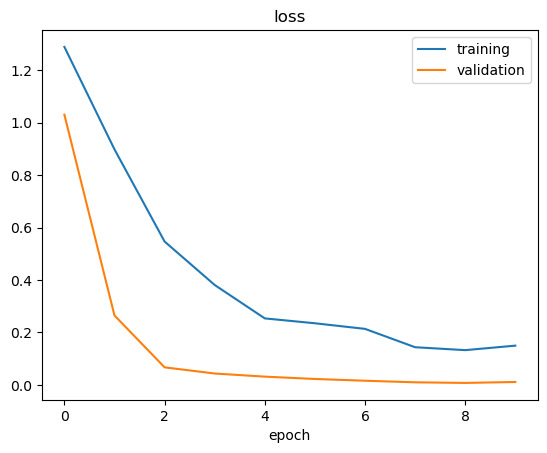

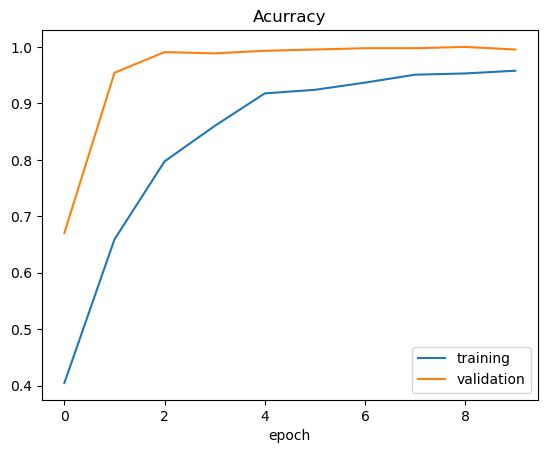

Test Score: 0.008996229618787766
Test Accuracy: 1.0


In [42]:
plt.figure(1)
plt.plot(history.history ['loss'])
plt.plot(history.history ['val_loss'])
plt.legend( ['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history ['accuracy'])
plt.plot(history.history ['val_accuracy'])
plt.legend( ['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score [0])
print('Test Accuracy:', score [1])

In [43]:
import joblib 

In [44]:
model.save('model.h5')

c:\Users\P50\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

In [46]:
frameWidth = 640  # CAMERA RESOLUTION
frameHeight = 480
brightness = 180
threshold = 0.75  # PROBABLITY THRESHOLD
font = cv2.FONT_HERSHEY_SIMPLEX

In [47]:
cap = cv2.VideoCapture(0)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10, brightness)


True

In [48]:
model = load_model('model.h5')

In [49]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255
    return img

In [50]:
def getCalssName(classNo):
    if classNo == 0:
        return 'Stop'
    elif classNo == 1:
        return 'Turn right ahead'
    elif classNo == 2:
        return 'Turn left ahead'
    elif classNo == 3:
        return 'Danger'

In [51]:
while True:
    # READ IMAGE
    success, imgOrignal = cap.read()

    # PROCESS IMAGE
    img = np.asarray(imgOrignal)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    cv2.imshow("Processed Image", img)
    img = img.reshape(1, 32, 32, 1)
    cv2.putText(imgOrignal, "CLASS: ", (20, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(imgOrignal, "PROBABILITY: ", (20, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)

    # PREDICT IMAGE
    predictions = model.predict(img)
    classIndex = np.argmax(predictions)
    probabilityValue = np.amax(predictions)

    if probabilityValue > threshold:
        cv2.putText(imgOrignal, str(classIndex) + " " + str(getCalssName(classIndex)), (120, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(imgOrignal, str(round(probabilityValue * 100, 2)) + "%", (180, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.imshow("Result", imgOrignal)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


1/1 [==============================] - 0s 43ms/step


: 